<a href="https://colab.research.google.com/github/alvinmhabieb/Portfolio/blob/main/Customer_Segmentation_Prediction_using_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

We invest in customers (acquisition costs, offline ads, promotions, discounts & etc.) to generate revenue and be profitable. Naturally, these actions make some customers super valuable in terms of lifetime value but there are always some customers who pull down the profitability. We need to identify these behavior patterns, segment customers and act accordingly. Calculating Lifetime Value is the easy part. First we need to select a time window. It can be anything like 3, 6, 12, 24 months. By the equation below, we can have Lifetime Value for each customer in that specific time window:

**Lifetime Value: Total Gross Revenue - Total Cost**

This equation now gives us the historical lifetime value. If we see some customers having very high negative lifetime value historically, it could be too late to take an action. We are going to build a simple machine learning model that predicts our customers lifetime value.

**Lifetime Value Prediction**
* Define an appropriate time frame for Customer Lifetime Value calculation
* Identify the features we are going to use to predict future and create them
* Calculate lifetime value (LTV) for training the machine learning model
* Build and run the machine learning model
* Check if the model is useful

Steps to calculate CLTV and running the model: 

**1. How to decide the timeframe**

Deciding the time frame really depends on your industry, business model, strategy and more. For some industries, 1 year is a very long period while for the others it is very short. In our example, we will go ahead with 6 months.

**2. Identifying the features for prediction**

RFM scores for each customer ID (which we calculated in the previous article) are the perfect candidates for feature set. To implement it correctly, we need to split our dataset. We will take 3 months of data, calculate RFM and use it for predicting next 6 months. So we need to create two dataframes first and append RFM scores to them.

After the first two steps, it is easy to calculate CLTV and train and test the model.

# Install & Load Packages

In [ ]:
!pip install lifetimes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 584 kB 8.4 MB/s 


In [ ]:
# numpy for array manipulation
import numpy as np
# pandas for dataframe manipulation
import pandas as pd
# matplotlib for data visualization
import matplotlib.pyplot as plt

#split training set and test set
from sklearn.model_selection import train_test_split
# import regression model
from sklearn.linear_model import LinearRegression
# import metrics module from scikit-learn
from sklearn import metrics

# load lifetimes plotting module
from lifetimes.plotting import *
# load lifetimes utils module
from lifetimes.utils import *
# load BetaGeoFitter model
from lifetimes import BetaGeoFitter
# load GammaGammaFitter
from lifetimes import GammaGammaFitter

# seaborn for preety data visualization
import seaborn as sns

# import datetime for date manipulation
import datetime as dt

# Data Inspection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/customer_segmentation.csv', encoding= 'unicode_escape')

In [ ]:
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


We have all the crucial information we need: Customer ID Unit Price Quantity Invoice Date Revenue = Active Customer Count Order Count Average Revenue per Order

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
columns_name =[]
unique_value=[]
# Iterate through the columns
for col in data:
    if data[col].dtype == 'object':
        # If 2 or fewer unique categories
        columns_name.append(str(col)) 
        unique_value.append(data[col].nunique())
table= pd.DataFrame()
table['Columns'] = columns_name
table['Unique']= unique_value
            
table=table.sort_values('Unique',ascending=False)
table

,Columns,Unique
0,InvoiceNo,25900
3,InvoiceDate,23260
2,Description,4223
1,StockCode,4070
4,Country,38


# Feature Engineering

In [ ]:
#converting the type of Invoice Date Field from string to datetime.
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [ ]:
#creating YearMonth field for the ease of reporting and visualization
data['InvoiceYearMonth'] = data['InvoiceDate'].map(lambda date: 100*date.year + date.month)

In [ ]:
data.describe()

,Quantity,UnitPrice,CustomerID,InvoiceYearMonth
count,541909.000000,541909.000000,406829.000000,541909.000000
mean,9.552250,4.611114,15287.690570,201099.713989
std,218.081158,96.759853,1713.600303,25.788703
min,-80995.000000,-11062.060000,12346.000000,201012.000000
25%,1.000000,1.250000,13953.000000,201103.000000
50%,3.000000,2.080000,15152.000000,201107.000000
75%,10.000000,4.130000,16791.000000,201110.000000
max,80995.000000,38970.000000,18287.000000,201112.000000


In [ ]:
data['Country'].value_counts()

United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

Starting from this part, we can get the monthly active customers by counting unique CustomerIDs.

# RFM Segmentation

You can do many different segmentations according to what you are trying to achieve. If you want to increase retention rate, you can do a segmentation based on churn probability and take actions. But there are very common and useful segmentation methods as well. Now we are going to implement one of them to our business: RFM. RFM stands for Recency - Frequency - Monetary Value. Theoretically we will have segments like below:
* Low Value: Customers who are less active than others, not very frequent buyer/visitor and generates very low - zero - maybe negative revenue.
* Mid Value: In the middle of everything. Often using our platform (but not as much as our High Values), fairly frequent and generates moderate revenue.
* High Value: The group we don’t want to lose. High Revenue, Frequency and low Inactivity.

As the methodology, we need to calculate Recency, Frequency and Monetary Value (we will call it Revenue from now on) and apply unsupervised machine learning to identify different groups (clusters) for each. Let’s jump into coding and see how to do RFM Clustering.

## Recency

To calculate recency, we need to find out most recent purchase date of each customer and see how many days they are inactive for. After having no. of inactive days for each customer, we will apply K-means* clustering to assign customers a recency score.

In [ ]:
#create a generic user dataframe to keep CustomerID and new segmentation scores
user = pd.DataFrame(data['CustomerID'].unique())
user.columns = ['CustomerID']
user.head()

,CustomerID
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0


In [ ]:
#get the max purchase date for each customer and create a dataframe with it
max_purchase = data.groupby('CustomerID').InvoiceDate.max().reset_index()
max_purchase.columns = ['CustomerID','MaxPurchaseDate']
max_purchase.head()

,CustomerID,MaxPurchaseDate
0,12346.0,2011-01-18 10:17:00
1,12347.0,2011-12-07 15:52:00
2,12348.0,2011-09-25 13:13:00
3,12349.0,2011-11-21 09:51:00
4,12350.0,2011-02-02 16:01:00


In [ ]:
# Compare the last transaction of the dataset with last transaction dates of the individual customer IDs.
max_purchase['Recency'] = (max_purchase['MaxPurchaseDate'].max() - max_purchase['MaxPurchaseDate']).dt.days
max_purchase.head()

,CustomerID,MaxPurchaseDate,Recency
0,12346.0,2011-01-18 10:17:00,325
1,12347.0,2011-12-07 15:52:00,1
2,12348.0,2011-09-25 13:13:00,74
3,12349.0,2011-11-21 09:51:00,18
4,12350.0,2011-02-02 16:01:00,309


In [ ]:
#merge this dataframe to our new user dataframe
user = pd.merge(user, max_purchase[['CustomerID','Recency']], on='CustomerID')
user.head()

,CustomerID,Recency
0,17850.0,301
1,13047.0,31
2,12583.0,2
3,13748.0,95
4,15100.0,329


### Recency Score

We are going to apply K-means clustering to assign a recency score. But we should tell how many clusters we need to K-means algorithm. To find it out, we will apply Elbow Method. Elbow Method simply tells the optimal cluster number for optimal inertia. Code snippet and Inertia graph are as follows:

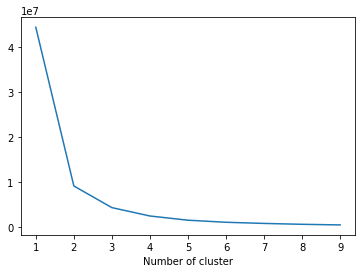

In [ ]:
from sklearn.cluster import KMeans

sse={} # error
recency = user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(recency)
    recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values 
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [ ]:
#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=4)
user['RecencyCluster'] = kmeans.fit_predict(user[['Recency']])

In [ ]:
user.head()

,CustomerID,Recency,RecencyCluster
0,17850.0,301,2
1,13047.0,31,3
2,12583.0,2,3
3,13748.0,95,0
4,15100.0,329,2


In [ ]:
user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,1062.0,77.967985,22.978638,48.0,59.0,73.0,94.00,132.0
1,638.0,186.858934,33.321405,133.0,157.0,184.5,214.75,247.0
2,515.0,307.794175,39.604027,248.0,273.0,304.0,338.00,373.0
3,2157.0,17.397311,13.188805,0.0,6.0,16.0,28.00,47.0


### Ordering Clusters

We have a cluster corresponding to each customerID. But each cluster is randomly assigned. Cluster 2 is not better than cluster 1 for e.g. and so on. We want to give clusters according to most recent transactions.

We will first find the mean of recency value corresponding to each cluster. Then we will sort these values. Let's say cluster 3 has the most recent transactions mean value. From the above table we see that cluster 1(mean recency 304) > cluster 2 > cluster 3 > cluster 0. That means that cluster 1 is most inactive and cluster 0 is most recent. We will give indices to these clusters as 0,1,2,3. So cluster 1 becomes cluster 0, cluster 2 becomes cluster 1, cluster 3 becomes cluster 2 and so on. Now we will drop the original cluster numbers and replace them with 0,1,2,3. Code is below.

In [ ]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,data,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    data_new = data.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    data_new = data_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    data_new['index'] = data_new.index
    data_final = pd.merge(data,data_new[[cluster_field_name,'index']], on=cluster_field_name)
    data_final = data_final.drop([cluster_field_name],axis=1)
    data_final = data_final.rename(columns={"index":cluster_field_name})
    return data_final

user = order_cluster('RecencyCluster', 'Recency', user,False)

In [ ]:
user.head()

,CustomerID,Recency,RecencyCluster
0,17850.0,301,0
1,15100.0,329,0
2,18074.0,373,0
3,16250.0,260,0
4,13747.0,373,0


In [ ]:
user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,515.0,307.794175,39.604027,248.0,273.0,304.0,338.00,373.0
1,638.0,186.858934,33.321405,133.0,157.0,184.5,214.75,247.0
2,1062.0,77.967985,22.978638,48.0,59.0,73.0,94.00,132.0
3,2157.0,17.397311,13.188805,0.0,6.0,16.0,28.00,47.0


Now the cluster 1 earlier change to cluster 0, cluster 2 earlier is now cluster 1 and so on. The clusters are arranged according to inactiviuty. Cluster 0 now is most inactive, cluster 3 is most active.

## Frequency

To create frequency clusters, we need to find total number orders for each customer. First calculate this and see how frequency look like in our customer database.

In [ ]:
#get order counts for each user and create a dataframe with it
frequency = data.groupby('CustomerID').InvoiceDate.count().reset_index()
frequency.columns = ['CustomerID','Frequency']

In [ ]:
#how many orders does a customer have
frequency.head() 

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [ ]:
#add this data to our main dataframe
user = pd.merge(user, frequency, on='CustomerID')
user.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,17850.0,301,0,312
1,15100.0,329,0,6
2,18074.0,373,0,13
3,16250.0,260,0,24
4,13747.0,373,0,1


### Frequency Clusters

Determine the right number of clusters for K-Means by elbow method.

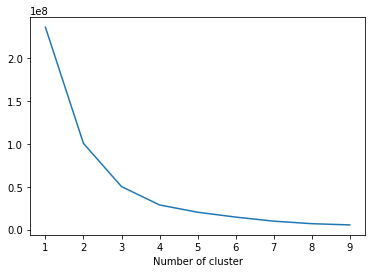

In [ ]:
from sklearn.cluster import KMeans

sse={} # error
recency = user[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(recency)
    recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values 
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

By Elbow method, clusters number should be 4 as after 4, the graph goes down.

In [ ]:
# Applying k-Means
kmeans=KMeans(n_clusters=4)
user['FrequencyCluster']=kmeans.fit_predict(user[['Frequency']])

#order the frequency cluster
user = order_cluster('FrequencyCluster', 'Frequency', user, True )
user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3862.0,49.753755,44.812998,1.0,15.0,34.0,73.0,189.0
1,482.0,329.107884,132.670589,190.0,228.0,286.0,393.5,803.0
2,24.0,1349.750000,508.637759,872.0,1003.5,1156.0,1541.0,2782.0
3,4.0,5914.000000,1473.845537,4642.0,5006.5,5515.5,6423.0,7983.0


Cluster with max frequency is cluster 3, least frequency cluster is cluster 0.

## Monetary

Now we analyzing how our customer database looks like when we cluster them based on revenue. We will calculate revenue for each customer, plot a histogram and apply the same clustering method.

In [ ]:
#calculate revenue for each customer
data['Revenue'] = data['UnitPrice'] * data['Quantity']
revenue = data.groupby('CustomerID').Revenue.sum().reset_index()

In [ ]:
revenue.head()

,CustomerID,Revenue
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [ ]:
#merge it with our main dataframe
user = pd.merge(user, revenue, on='CustomerID')
user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,17850.0,301,0,312,1,5288.63
1,15808.0,305,0,210,1,3724.77
2,13047.0,31,3,196,1,3079.10
3,12583.0,2,3,251,1,7187.34
4,14688.0,7,3,359,1,5107.38


### Revenue Clustering

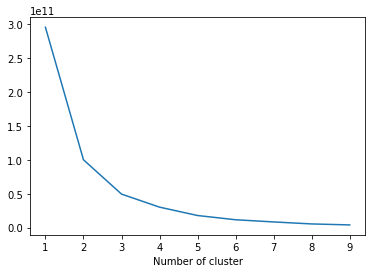

In [ ]:
from sklearn.cluster import KMeans

sse={} # error
recency = user[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(recency)
    recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values 
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

From elbow's method, we find that clusters can be 3 or 4. Lets take 4 as the number of clusters.

In [ ]:
#apply clustering
kmeans = KMeans(n_clusters=4)
user['RevenueCluster'] = kmeans.fit_predict(user[['Revenue']])

#order the cluster numbers
user = order_cluster('RevenueCluster', 'Revenue',user,True)

#show details of the dataframe
user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,4236.0,1134.984243,1341.853197,-4287.63,284.340,621.445,1451.6775,7711.38
1,118.0,14385.679153,7469.596324,7741.47,9183.665,11278.925,16365.5800,40340.78
2,15.0,71423.516000,28632.631870,50415.49,52287.280,57385.880,77008.7300,132572.62
3,3.0,241136.560000,47874.073443,187482.17,221960.330,256438.490,267963.7550,279489.02


Cluster 3 has max revenue, cluster 0 has lowest revenue.

# Overall Score based on RFM Clustering

We have scores (cluster numbers) for recency, frequency & revenue. Let’s create an overall score out of them.

In [ ]:
#calculate overall score and use mean() to see details
user['OverallScore'] = user['RecencyCluster'] + user['FrequencyCluster'] + user['RevenueCluster']
user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,307.894531,21.810547,332.398203
1,187.515008,33.535545,551.794599
2,78.893762,46.886940,916.327984
3,20.428237,70.649678,1246.147523
4,13.416667,302.447917,4388.008698
5,7.400000,491.435294,13810.254706
6,7.307692,985.230769,38669.643077
7,2.555556,2432.555556,98056.746667
8,1.333333,4372.000000,156394.183333


We can see that score 8 is our best customer; score 0 is our worst customer.

In [ ]:
user['Segment'] = 'Low-Value'
user.loc[user['OverallScore'] > 2,'Segment'] = 'Mid-Value' 
user.loc[user['OverallScore'] > 4,'Segment'] = 'High-Value' 

In [ ]:
user

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,17850.0,301,0,312,1,5288.63,0,1,Low-Value
1,15808.0,305,0,210,1,3724.77,0,1,Low-Value
2,13047.0,31,3,196,1,3079.10,0,4,Mid-Value
3,12583.0,2,3,251,1,7187.34,0,4,Mid-Value
4,14688.0,7,3,359,1,5107.38,0,4,Mid-Value
...,...,...,...,...,...,...,...,...,...
4367,12748.0,0,3,4642,3,29072.10,1,7,High-Value
4368,17841.0,1,3,7983,3,40340.78,1,7,High-Value
4369,17450.0,7,3,351,1,187482.17,3,7,High-Value
4370,18102.0,0,3,433,1,256438.49,3,7,High-Value


# Customer Lifetime Value

Since our feature set is ready, let’s calculate 6 months LTV for each customer which we are going to use for training our model:

**Lifetime Value: Total Gross Revenue - Total Cost**

There is no cost specified in the dataset. That’s why Revenue becomes our LTV directly.

In [ ]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34


In [ ]:
data['InvoiceDate'].describe()

count                  541909
unique                  23260
top       2011-10-31 14:41:00
freq                     1114
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

We can see that customers are active from 1 December 2010. Let us consider customers from March onwards (so that they are not new customers). We shall divide them into 2 subgroups. One will be where timeframe of analysing is 3 months, another will be timeframe of 6 months.

In [ ]:
from datetime import date

data.InvoiceDate = pd.to_datetime(data.InvoiceDate)
data.InvoiceDate = pd.to_datetime(data.InvoiceDate).dt.date

In [ ]:
data.InvoiceDate

0         2010-12-01
1         2010-12-01
2         2010-12-01
3         2010-12-01
4         2010-12-01
             ...    
541904    2011-12-09
541905    2011-12-09
541906    2011-12-09
541907    2011-12-09
541908    2011-12-09
Name: InvoiceDate, Length: 541909, dtype: object

In [ ]:
from datetime import date

# 3 months time
dt_3m = data[(data.InvoiceDate < date(2011,6,1)) & (data.InvoiceDate >= date(2011,3,1))].reset_index(drop=True)

# 6 months time
dt_6m = data[(data.InvoiceDate >= date(2011,6,1)) & (data.InvoiceDate < date(2011,12,1))].reset_index(drop=True) 

## 3 Months Revenue

In [ ]:
dt_3m

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue
0,545220,21955,DOORMAT UNION JACK GUNS AND ROSES,2,2011-03-01,7.95,14620.0,United Kingdom,201103,15.90
1,545220,48194,DOORMAT HEARTS,2,2011-03-01,7.95,14620.0,United Kingdom,201103,15.90
2,545220,22556,PLASTERS IN TIN CIRCUS PARADE,12,2011-03-01,1.65,14620.0,United Kingdom,201103,19.80
3,545220,22139,RETROSPOT TEA SET CERAMIC 11 PC,3,2011-03-01,4.95,14620.0,United Kingdom,201103,14.85
4,545220,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,4,2011-03-01,3.75,14620.0,United Kingdom,201103,15.00
...,...,...,...,...,...,...,...,...,...,...
103689,555150,22895,SET OF 2 TEA TOWELS APPLE AND PEARS,3,2011-05-31,3.25,NaN,United Kingdom,201105,9.75
103690,555150,22983,CARD BILLBOARD FONT,3,2011-05-31,0.42,NaN,United Kingdom,201105,1.26
103691,555150,23169,CLASSIC GLASS COOKIE JAR,3,2011-05-31,4.15,NaN,United Kingdom,201105,12.45
103692,555150,23298,SPOTTY BUNTING,5,2011-05-31,4.95,NaN,United Kingdom,201105,24.75


In [ ]:
#calculate revenue and create a new dataframe for it
dt_3m['Revenue'] = dt_3m['UnitPrice'] * dt_3m['Quantity']
user_3m = dt_3m.groupby('CustomerID')['Revenue'].sum().reset_index()
user_3m.columns = ['CustomerID','3m_Revenue']

In [ ]:
user_3m.head()

,CustomerID,3m_Revenue
0,12347.0,636.25
1,12348.0,367.00
2,12352.0,304.68
3,12353.0,89.00
4,12354.0,1079.40


In [ ]:
import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

#plot LTV histogram
plot_data = [
    go.Histogram(
        x=user_3m['3m_Revenue']
    )
]

plot_layout = go.Layout(
        title='3 Month Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In 3 months revenue histogram shows we have customers with negative LTV. We have some outliers too. Filtering out the outliers makes sense to have a proper machine learning model.

## 6 Months Revenue

In [ ]:
dt_6m

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue
0,555156,23299,FOOD COVER WITH BEADS SET 2,6,2011-06-01,3.75,15643.0,United Kingdom,201106,22.50
1,555156,22847,BREAD BIN DINER STYLE IVORY,1,2011-06-01,16.95,15643.0,United Kingdom,201106,16.95
2,555157,23075,PARLOUR CERAMIC WALL HOOK,16,2011-06-01,4.15,15643.0,United Kingdom,201106,66.40
3,555157,47590B,PINK HAPPY BIRTHDAY BUNTING,6,2011-06-01,5.45,15643.0,United Kingdom,201106,32.70
4,555157,22423,REGENCY CAKESTAND 3 TIER,4,2011-06-01,12.75,15643.0,United Kingdom,201106,51.00
...,...,...,...,...,...,...,...,...,...,...
307350,C579886,22197,POPCORN HOLDER,-1,2011-11-30,0.85,15676.0,United Kingdom,201111,-0.85
307351,C579886,23146,TRIPLE HOOK ANTIQUE IVORY ROSE,-1,2011-11-30,3.29,15676.0,United Kingdom,201111,-3.29
307352,C579887,84946,ANTIQUE SILVER T-LIGHT GLASS,-1,2011-11-30,1.25,16717.0,United Kingdom,201111,-1.25
307353,C579887,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2011-11-30,7.95,16717.0,United Kingdom,201111,-7.95


In [ ]:
#calculate revenue and create a new dataframe for it
dt_6m['Revenue'] = dt_6m['UnitPrice'] * dt_6m['Quantity']
user_6m = dt_6m.groupby('CustomerID')['Revenue'].sum().reset_index()
user_6m.columns = ['CustomerID','6m_Revenue']

In [ ]:
user_6m.head()

,CustomerID,6m_Revenue
0,12347.0,2261.75
1,12348.0,310.00
2,12349.0,1757.55
3,12352.0,944.23
4,12356.0,58.35


In [ ]:
import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

#plot LTV histogram
plot_data = [
    go.Histogram(
        x=user_6m['6m_Revenue']
    )
]

plot_layout = go.Layout(
        title='6 Month Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In 6 months revenue histogram shows we have customers with negative LTV. We have some outliers too. Filtering out the outliers makes sense to have a proper machine learning model.

# Lifetime Value

We will merge our 3 months and also merge 6 months data and user dataset to see correlations between LTV and the feature set we have.

In [ ]:
user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,17850.0,301,0,312,1,5288.63,0,1,Low-Value
1,15808.0,305,0,210,1,3724.77,0,1,Low-Value
2,13047.0,31,3,196,1,3079.10,0,4,Mid-Value
3,12583.0,2,3,251,1,7187.34,0,4,Mid-Value
4,14688.0,7,3,359,1,5107.38,0,4,Mid-Value


In [ ]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,201012,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,201012,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,201012,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,201012,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,201012,20.34


## 3 Months

In [ ]:
# Only people who are in the timeline of user in 3 months
dt_3m = pd.merge(user, user_3m, on='CustomerID', how='left')

In [ ]:
dt_3m = dt_3m.fillna(0)

In [ ]:
dt_3m

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,3m_Revenue
0,17850.0,301,0,312,1,5288.63,0,1,Low-Value,0.00
1,15808.0,305,0,210,1,3724.77,0,1,Low-Value,0.00
2,13047.0,31,3,196,1,3079.10,0,4,Mid-Value,831.10
3,12583.0,2,3,251,1,7187.34,0,4,Mid-Value,1134.81
4,14688.0,7,3,359,1,5107.38,0,4,Mid-Value,1296.31
...,...,...,...,...,...,...,...,...,...,...
4367,12748.0,0,3,4642,3,29072.10,1,7,High-Value,4336.73
4368,17841.0,1,3,7983,3,40340.78,1,7,High-Value,5985.21
4369,17450.0,7,3,351,1,187482.17,3,7,High-Value,35085.48
4370,18102.0,0,3,433,1,256438.49,3,7,High-Value,26113.81


In [ ]:
graph = dt_3m.query("Revenue < 50000") #because max values are ending at 50,000 as seen in graph above

plot_data = [
    go.Scatter(
        x=graph.query("Segment == 'Low-Value'")['OverallScore'],
        y=graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=graph.query("Segment == 'Mid-Value'")['OverallScore'],
        y=graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=graph.query("Segment == 'High-Value'")['OverallScore'],
        y=graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "LTV in 3 Months"},
        xaxis= {'title': "RFM Score"},
        title='Lifetime Value'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

We can visualise correlation between overall RFM score and revenue. Positive correlation is quite visible here. High RFM score means high LTV.

Before building the machine learning model, we need to identify what is the type of this machine learning problem. LTV itself is a regression problem. A machine learning model can predict the $ value of the LTV. But here, we want LTV segments. Because it makes it more actionable and easy to communicate with other people. By applying K-means clustering, we can identify our existing LTV groups and build segments on top of it.

In [ ]:
#remove outliers
dt_3m = dt_3m[dt_3m['Revenue']< dt_3m['Revenue'].quantile(0.99)]

In [ ]:
graph = dt_3m.query("Revenue < 50000") #because max values are ending at 50,000 as seen in graph above

plot_data = [
    go.Scatter(
        x=graph.query("Segment == 'Low-Value'")['OverallScore'],
        y=graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=graph.query("Segment == 'Mid-Value'")['OverallScore'],
        y=graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=graph.query("Segment == 'High-Value'")['OverallScore'],
        y=graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "LTV in 3 Months"},
        xaxis= {'title': "RFM Score"},
        title='Lifetime Value'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [ ]:
dt_3m.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,3m_Revenue
0,17850.0,301,0,312,1,5288.63,0,1,Low-Value,0.00
1,15808.0,305,0,210,1,3724.77,0,1,Low-Value,0.00
2,13047.0,31,3,196,1,3079.10,0,4,Mid-Value,831.10
3,12583.0,2,3,251,1,7187.34,0,4,Mid-Value,1134.81
4,14688.0,7,3,359,1,5107.38,0,4,Mid-Value,1296.31


In [ ]:
#creating 3 clusters
kmeans = KMeans(n_clusters=3)
dt_3m['LTVCluster'] = kmeans.fit_predict(dt_3m[['Revenue']])

dt_3m.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,3m_Revenue,LTVCluster
0,17850.0,301,0,312,1,5288.63,0,1,Low-Value,0.00,0
1,15808.0,305,0,210,1,3724.77,0,1,Low-Value,0.00,0
2,13047.0,31,3,196,1,3079.10,0,4,Mid-Value,831.10,0
3,12583.0,2,3,251,1,7187.34,0,4,Mid-Value,1134.81,1
4,14688.0,7,3,359,1,5107.38,0,4,Mid-Value,1296.31,0


In [ ]:
#order cluster number based on LTV
dt_3m = order_cluster('LTVCluster', 'Revenue', dt_3m,True)

#creatinga new cluster dataframe
cluster_3m = dt_3m.copy()

#see details of the clusters
cluster_3m.groupby('LTVCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,3483.0,615.229226,498.678055,-4287.63,233.905,463.380,901.205,1967.25
1,709.0,3326.621736,1136.151849,1976.12,2385.800,3021.770,3974.370,6423.60
2,136.0,9668.039926,2861.817077,6500.60,7183.180,8922.065,11141.975,17078.45


In [ ]:
cluster_3m.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,3m_Revenue,LTVCluster
0,17850.0,301,0,312,1,5288.63,0,1,Low-Value,0.00,1
1,15808.0,305,0,210,1,3724.77,0,1,Low-Value,0.00,1
2,13047.0,31,3,196,1,3079.10,0,4,Mid-Value,831.10,1
3,14688.0,7,3,359,1,5107.38,0,4,Mid-Value,1296.31,1
4,12431.0,35,3,240,1,6416.39,0,4,Mid-Value,937.35,1


### Feature Engineering

In [ ]:
#convert categorical columns to numerical
class_3m = pd.get_dummies(cluster_3m) #There is only one categorical variable segment
class_3m.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,3m_Revenue,LTVCluster,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,17850.0,301,0,312,1,5288.63,0,1,0.00,1,0,1,0
1,15808.0,305,0,210,1,3724.77,0,1,0.00,1,0,1,0
2,13047.0,31,3,196,1,3079.10,0,4,831.10,1,0,0,1
3,14688.0,7,3,359,1,5107.38,0,4,1296.31,1,0,0,1
4,12431.0,35,3,240,1,6416.39,0,4,937.35,1,0,0,1


In [ ]:
#calculate and show correlations
corr_matrix = class_3m.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster            1.000000
Revenue               0.878166
3m_Revenue            0.665651
Frequency             0.601924
FrequencyCluster      0.544148
RevenueCluster        0.535546
OverallScore          0.464980
Segment_High-Value    0.453547
RecencyCluster        0.292721
Segment_Mid-Value     0.208345
CustomerID           -0.062156
Recency              -0.286470
Segment_Low-Value    -0.326570
Name: LTVCluster, dtype: float64

In [ ]:
#create X and y, X will be feature set and y is the label - LTV
X = class_3m.drop(['LTVCluster','Revenue'],axis=1)
y = class_3m['LTVCluster']

In [ ]:
# split data to train and test data
# with test size is 2% of overall data
# use stratified sampling
# and set RNG to 1000
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.02,
    stratify = y,
    random_state = 56
)

### Customer Lifetime Value Prediction using Machine Learning Model (XGBoost) 

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(max_depth=5, learning_rate=0.1,n_jobs=-1).fit(X_train, y_train)
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb.score(X_test[X_train.columns], y_test)))

y_pred = xgb.predict(X_test)

Accuracy of XGB classifier on training set: 0.95
Accuracy of XGB classifier on test set: 0.97


In [ ]:
# Classification Report
pd.DataFrame(metrics.classification_report(y_test, y_pred, output_dict=True))

,0,1,2,accuracy,macro avg,weighted avg
precision,0.971831,0.923077,1.0,0.965517,0.964969,0.964957
recall,0.985714,0.857143,1.0,0.965517,0.947619,0.965517
f1-score,0.978723,0.888889,1.0,0.965517,0.955871,0.965001
support,70.000000,14.000000,3.0,0.965517,87.000000,87.000000


## 6 Months

In [ ]:
# Only people who are in the timeline of user in 6 months
dt_6m = pd.merge(user, user_3m, on='CustomerID', how='left')

In [ ]:
dt_6m = dt_6m.fillna(0)

In [ ]:
dt_6m

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,3m_Revenue
0,17850.0,301,0,312,1,5288.63,0,1,Low-Value,0.00
1,15808.0,305,0,210,1,3724.77,0,1,Low-Value,0.00
2,13047.0,31,3,196,1,3079.10,0,4,Mid-Value,831.10
3,12583.0,2,3,251,1,7187.34,0,4,Mid-Value,1134.81
4,14688.0,7,3,359,1,5107.38,0,4,Mid-Value,1296.31
...,...,...,...,...,...,...,...,...,...,...
4367,12748.0,0,3,4642,3,29072.10,1,7,High-Value,4336.73
4368,17841.0,1,3,7983,3,40340.78,1,7,High-Value,5985.21
4369,17450.0,7,3,351,1,187482.17,3,7,High-Value,35085.48
4370,18102.0,0,3,433,1,256438.49,3,7,High-Value,26113.81


In [ ]:
graph = dt_6m.query("Revenue < 50000") #because max values are ending at 50,000 as seen in graph above

plot_data = [
    go.Scatter(
        x=graph.query("Segment == 'Low-Value'")['OverallScore'],
        y=graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=graph.query("Segment == 'Mid-Value'")['OverallScore'],
        y=graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=graph.query("Segment == 'High-Value'")['OverallScore'],
        y=graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "LTV in 6 Months"},
        xaxis= {'title': "RFM Score"},
        title='Lifetime Value'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

We can visualise correlation between overall RFM score and revenue. Positive correlation is quite visible here. High RFM score means high LTV.

Before building the machine learning model, we need to identify what is the type of this machine learning problem. LTV itself is a regression problem. A machine learning model can predict the $ value of the LTV. But here, we want LTV segments. Because it makes it more actionable and easy to communicate with other people. By applying K-means clustering, we can identify our existing LTV groups and build segments on top of it.

In [ ]:
#remove outliers
dt_6m = dt_6m[dt_6m['Revenue']< dt_6m['Revenue'].quantile(0.99)]

In [ ]:
graph = dt_6m.query("Revenue < 50000") #because max values are ending at 50,000 as seen in graph above

plot_data = [
    go.Scatter(
        x=graph.query("Segment == 'Low-Value'")['OverallScore'],
        y=graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=graph.query("Segment == 'Mid-Value'")['OverallScore'],
        y=graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=graph.query("Segment == 'High-Value'")['OverallScore'],
        y=graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "LTV in 6 Months"},
        xaxis= {'title': "RFM Score"},
        title='Lifetime Value'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [ ]:
dt_6m.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,3m_Revenue
0,17850.0,301,0,312,1,5288.63,0,1,Low-Value,0.00
1,15808.0,305,0,210,1,3724.77,0,1,Low-Value,0.00
2,13047.0,31,3,196,1,3079.10,0,4,Mid-Value,831.10
3,12583.0,2,3,251,1,7187.34,0,4,Mid-Value,1134.81
4,14688.0,7,3,359,1,5107.38,0,4,Mid-Value,1296.31


In [ ]:
#creating 3 clusters
kmeans = KMeans(n_clusters=3)
dt_6m['LTVCluster'] = kmeans.fit_predict(dt_6m[['Revenue']])

dt_6m.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,3m_Revenue,LTVCluster
0,17850.0,301,0,312,1,5288.63,0,1,Low-Value,0.00,2
1,15808.0,305,0,210,1,3724.77,0,1,Low-Value,0.00,2
2,13047.0,31,3,196,1,3079.10,0,4,Mid-Value,831.10,2
3,12583.0,2,3,251,1,7187.34,0,4,Mid-Value,1134.81,1
4,14688.0,7,3,359,1,5107.38,0,4,Mid-Value,1296.31,2


In [ ]:
#order cluster number based on LTV
dt_6m = order_cluster('LTVCluster', 'Revenue', dt_6m,True)

#creatinga new cluster dataframe
cluster_6m = dt_6m.copy()

#see details of the clusters
cluster_6m.groupby('LTVCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,3483.0,615.229226,498.678055,-4287.63,233.905,463.380,901.2050,1967.25
1,710.0,3331.092128,1141.581929,1976.12,2389.065,3023.195,3977.8725,6500.60
2,135.0,9691.502444,2859.316535,6530.04,7230.045,8933.520,11166.9000,17078.45


In [ ]:
cluster_6m.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,3m_Revenue,LTVCluster
0,17850.0,301,0,312,1,5288.63,0,1,Low-Value,0.00,1
1,15808.0,305,0,210,1,3724.77,0,1,Low-Value,0.00,1
2,13047.0,31,3,196,1,3079.10,0,4,Mid-Value,831.10,1
3,14688.0,7,3,359,1,5107.38,0,4,Mid-Value,1296.31,1
4,12431.0,35,3,240,1,6416.39,0,4,Mid-Value,937.35,1


### Feature Engineering

In [ ]:
#convert categorical columns to numerical
class_6m = pd.get_dummies(cluster_6m) #There is only one categorical variable segment
class_6m.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,3m_Revenue,LTVCluster,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,17850.0,301,0,312,1,5288.63,0,1,0.00,1,0,1,0
1,15808.0,305,0,210,1,3724.77,0,1,0.00,1,0,1,0
2,13047.0,31,3,196,1,3079.10,0,4,831.10,1,0,0,1
3,14688.0,7,3,359,1,5107.38,0,4,1296.31,1,0,0,1
4,12431.0,35,3,240,1,6416.39,0,4,937.35,1,0,0,1


In [ ]:
#calculate and show correlations
corr_matrix = class_6m.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster            1.000000
Revenue               0.878017
3m_Revenue            0.665019
Frequency             0.601766
FrequencyCluster      0.543545
RevenueCluster        0.536279
OverallScore          0.464866
Segment_High-Value    0.454171
RecencyCluster        0.292678
Segment_Mid-Value     0.208110
CustomerID           -0.062650
Recency              -0.286454
Segment_Low-Value    -0.326499
Name: LTVCluster, dtype: float64

In [ ]:
#create X and y, X will be feature set and y is the label - LTV
X = class_6m.drop(['LTVCluster','Revenue'],axis=1)
y = class_6m['LTVCluster']

In [ ]:
# split data to train and test data
# with test size is 2% of overall data
# use stratified sampling
# and set RNG to 1000
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.02,
    stratify = y,
    random_state = 56
)

### Customer Lifetime Value Prediction using Machine Learning Model (XGBoost) 

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(max_depth=5, learning_rate=0.1,n_jobs=-1).fit(X_train, y_train)
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb.score(X_test[X_train.columns], y_test)))

y_pred = xgb.predict(X_test)

Accuracy of XGB classifier on training set: 0.95
Accuracy of XGB classifier on test set: 0.94


In [ ]:
# Classification Report
pd.DataFrame(metrics.classification_report(y_test, y_pred, output_dict=True))

,0,1,2,accuracy,macro avg,weighted avg
precision,0.958333,0.846154,1.000000,0.942529,0.934829,0.941718
recall,0.985714,0.785714,0.666667,0.942529,0.812698,0.942529
f1-score,0.971831,0.814815,0.800000,0.942529,0.862215,0.940639
support,70.000000,14.000000,3.000000,0.942529,87.000000,87.000000


# Summary

We divided the clusters by 3:
* Cluster 0: Good precision, recall, f1-score and support
* Cluster 1: Needs better precision, recall and f1-score
* Cluster 2: Bad precision, F1-Score needs improvement

If model tells us this customer belongs to cluster 0, 93 out of 100 will be correct (precision). And the model successfully identifies 95% of actual cluster 0 customers (recall). We really need to improve the model for other clusters. For example, we barely detect 67% of Mid LTV customers.

We also recommended to make some possibility actions to improve performance:
* Adding more features and improve feature engineering
* Try different models other than XGBoost
* Apply hyper parameter tuning to current model
* Add more data to the model if possible